# Support Vector Machines
## Acamica - Bitácora 25

## 1. Preprocesamiento y Entrenamiento de Modelo

Vamos a trabajar con el dataset de Social Networks Ads, un conjunto de datos que permiten determinar si un usuario compró o no un producto en particular.  
Tanto el dataset como su descripción los pueden encontrar en [Kaggle](https://www.kaggle.com/rakeshrau/social-network-ads).

### 1.1. Analisis exploratorio
### Columnas del dataset:
* User ID: identificación de usuario.
* Gender: género.
* Age: edad.
* EstimatedSalary: salario estimado.
* Purchased: compró/no compró un producto en particular.

Importar las librerías necesarias y carga el dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = pd.read_csv('ads.csv')
dataset.head(10)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
5,15728773,Male,27,58000,0
6,15598044,Female,27,84000,0
7,15694829,Female,32,150000,1
8,15600575,Male,25,33000,0
9,15727311,Female,35,65000,0


### 1.2. Preprocesamiento
Sólo vamos a utilizar como features las columnas `Age` y `EstimatedSalary`, y como target a la columna `Purchased`

In [4]:
X = dataset.iloc[:, [2, 3]].values
Y = dataset.iloc[:, 4].values

Separamos los datos de entrenamiento de los datos de prueba:

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=42)

### 1.3. Entrenamiento de modelo
Estandarizamos los datos y entrenamos un SVM:

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

steps = [('scaler', StandardScaler()),
         ('clf', SVC(kernel='linear', random_state=42))]

pipeline = Pipeline(steps)
clf = pipeline.fit(x_train, y_train)

### 1.4. Predicciones y validación
Realizamos las predicciones sobre los datos de prueba:

In [7]:
y_pred = clf.predict(x_test)
y_pred

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0])

Visualizamos los resultados mediante una Matriz de confusión

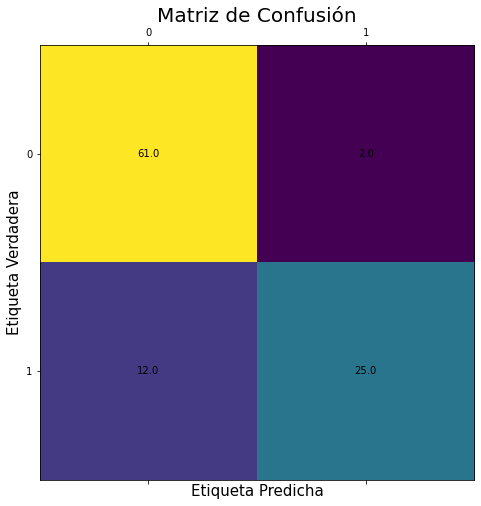

In [8]:
# Matriz de confusión 
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

## 2. Guardar modelo entrenado
Guardamos el modelo entrenado como un pickle

In [9]:
import pickle

pickle.dump(clf, open('model.pkl','wb'))

## 3. Cargar modelo entrenado
Cargamos el modelo entrenado y lo utilizamos para hacer predicciones

In [10]:
model = pickle.load(open('model.pkl','rb'))

In [15]:
age=25
salary=150000

model.predict(np.array([[age, salary]]))

array([0])

## 4. App Flask 
Crear un archivo `app.py` con el siguiente código.   
Se debe tener en cuenta que esta app hace uso de librerías como `flask`, `pickle`

In [ ]:
import os
import pandas as pd 
import numpy as np 
import flask
import pickle
from flask import Flask, render_template, request, jsonify

app=Flask(__name__)

@app.route("/test", methods=["GET"])
def ping():
    """
    Metodo para probar que la app esté funcionando correctamente.
    Ejecución: http://host:port/test
    """
    return jsonify({"response": "Running..."})


@app.route('/')
def index():
    """
    Metodo para acceder a la portada inicial de la app.
    Ejecución: http://host:port
    """ 
    return flask.render_template('index.html')

def ValuePredictor(to_predict_list):
    """
    Función que carga el modelo previamente entrenado y obtiene la predicción de los nuevos datos
    """
    to_predict = np.array(to_predict_list).reshape(1,2)
    loaded_model = pickle.load(open('model.pkl','rb'))
    result = loaded_model.predict(to_predict)
    return result[0]


@app.route('/predict',methods = ['GET'])
def result():
    """
    Metodo para capturar los parametros de entrada y retornar el resultado de la predicción.
    Ejecución: Se ejecuta desde un FORM HTML en la página templates/index.html
    """
    if request.method == 'GET':
        to_predict_list = request.form.to_dict()
        to_predict_list=list(to_predict_list.values())
        to_predict_list = list(map(float, to_predict_list))
        result = ValuePredictor(to_predict_list)
        
        if result == 1:
            prediction = "Compra"
        else:
            prediction = "No Compra"
        
        return render_template('index.html', prediction=prediction)



@app.route('/predict/params')
def result_params():
    """
    Metodo para calcular una predicción pasando los valores como parámetros en la URL y 
    retorna un JSON con el resultado.
    Ejecución: http://127.0.0.1:5000/predict/params?edad=XX&salario=YYYYY
    """
    args = request.args
    edad = args.get("edad")
    salario = args.get("salario")

    result = ValuePredictor([int(edad), int(salario)])
    if result == 1:
        prediction = "Compra"
    else:
        prediction = "No Compra"

    return jsonify({"prediccion": prediction})
    

if __name__ == '__main__':
    app.run(debug=True)